In [1]:
import sys,os,errno,signal,copy
from contextlib import contextmanager
# !pip install intervaltree
import numpy as np
import musicnet

import torch
import torch.nn.functional as F
from torch.autograd import Variable
from torch.nn.functional import conv1d, mse_loss, cross_entropy
print(torch.__version__)
from time import time

import matplotlib.pyplot as plt
from IPython.display import Audio

from sklearn.metrics import average_precision_score

root = '/mnt/musicnet/'
checkpoint_path = './checkpoints'
checkpoint = 'musicnet_demo.pt'

try:
    os.makedirs(checkpoint_path)
except OSError as e:
    if e.errno != errno.EEXIST:
        raise

%matplotlib inline

0.3.1


In [2]:
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'   # see issue #152
os.environ['CUDA_VISIBLE_DEVICES']='1,2,3'

def worker_init(args):
    signal.signal(signal.SIGINT, signal.SIG_IGN) # ignore signals so parent can handle them
    np.random.seed(os.getpid() ^ int(time())) # approximately random seed for workers

batch_size = 100
kwargs = {'num_workers': 4, 'pin_memory': True, 'worker_init_fn': worker_init}

m = 128
k = 512
d = 4096
window = 16384
stride = 512
regions = 1 + (window - d)/stride

In [3]:
train_set = musicnet.MusicNet(root=root, train=True, download=False, window=window)#, pitch_shift=5, jitter=.1)
test_set = musicnet.MusicNet(root=root, train=False, window=window, epoch_size=50000)

In [4]:
naruto_test = musicnet.MusicNet(root=root, train=False, window=window, download=False, epoch_size=50000, naruto=True)

In [5]:
train_loader = torch.utils.data.DataLoader(dataset=train_set,batch_size=batch_size,**kwargs)
test_loader = torch.utils.data.DataLoader(dataset=test_set,batch_size=batch_size,**kwargs)
naruto_loader = torch.utils.data.DataLoader(dataset=naruto_test,batch_size=batch_size,**kwargs)

In [6]:
def create_filters(d,k,low=50,high=6000):
    x = np.linspace(0, 2*np.pi, d, endpoint=False)
    wsin = np.empty((k,1,d), dtype=np.float32)
    wcos = np.empty((k,1,d), dtype=np.float32)
    start_freq = low
    end_freq = high
    num_cycles = start_freq*d/44000.
    scaling_ind = np.log(end_freq/start_freq)/k
    window_mask = 1.0-1.0*np.cos(x)
    for ind in range(k):
        wsin[ind,0,:] = window_mask*np.sin(np.exp(ind*scaling_ind)*num_cycles*x)
        wcos[ind,0,:] = window_mask*np.cos(np.exp(ind*scaling_ind)*num_cycles*x)
    
    return wsin,wcos

In [7]:
def L(y_hat, y):
    # adjust for per-frame loss
    return mse_loss(y_hat, y)*128/2.

def L(y_hat, y):
    # adjust for per-frame loss
    return cross_entropy(y_hat, y.type(torch.cuda.LongTensor))

In [8]:
class Flatten(torch.nn.Module):
    def forward(self, input):
        return input.view(input.size(0), -1)

In [9]:
class Model(torch.nn.Module):
    def __init__(self, avg=.9998):
        super(Model, self).__init__()
        
        wsin,wcos = create_filters(d,k)
        with torch.cuda.device(0):
            self.wsin_var = Variable(torch.from_numpy(wsin).cuda(), requires_grad=False)
            self.wcos_var = Variable(torch.from_numpy(wcos).cuda(), requires_grad=False)
        h1 = 256
        h2 = 256
        self.seq = torch.nn.Sequential()
        conv1_stride = 1
        self.seq.add_module('drop', torch.nn.Dropout())
#         self.seq.add_module('bn', torch.nn.BatchNorm1d())
        
        self.seq.add_module('l1', torch.nn.Linear(int(regions*k), 512, bias=False))
        self.seq.add_module('relu1', torch.nn.ELU())
        self.seq.add_module('l2', torch.nn.Linear(512, 256, bias=False))
        self.seq.add_module('relu2', torch.nn.ELU())
        self.seq.add_module('drop2', torch.nn.Dropout())        
        self.seq.add_module('l3', torch.nn.Linear(256, 128, bias=False))
        self.seq.add_module('relu4', torch.nn.ELU())
        self.seq.add_module('lout', torch.nn.Linear(int(128), int(m), bias=False))


        self.seq.add_module('out', torch.nn.Softmax())
    
    
#         self.seq.add_module('out', torch.nn.LogSigmoid())
#         self.seq.add_module('out', torch.nn.Sigmoid())
#         self.linear = torch.nn.Linear(int(regions*k), int(h), bias=False).cuda()
#         torch.nn.init.xavier_uniform(self.linear.weight)
#         self.linear2 = torch.nn.Linear(int(h), int(h), bias=False).cuda()
#         torch.nn.init.xavier_uniform(self.linear2.weight)
#         self.linear3 = torch.nn.Linear(int(h), int(m), bias=False).cuda()
#         torch.nn.init.xavier_uniform(self.linear3.weight)
        self.seq.cuda()
        self.avg = avg
        self.averages = copy.deepcopy(list(parm.data for parm in self.parameters()))
        for (name,parm),pavg in zip(self.named_parameters(),self.averages):
            self.register_buffer(name + '.avg', pavg)
    
    def forward(self, x):
#         print(x.size())
        zx = conv1d(x[:,None,:], self.wsin_var, stride=stride).pow(2) \
           + conv1d(x[:,None,:], self.wcos_var, stride=stride).pow(2)
#         print(zx.size())
#         hid = self.linear(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],int(regions*k)))
#         hid2 = self.linear2(F.relu(hid))
#         hid3 = self.linear3(F.relu(hid2))
#         return F.softmax(hid3)
        return self.seq.forward(torch.log(zx + musicnet.epsilon).view(x.data.size()[0],int(regions*k)))
#         return self.seq.forward(torch.log(zx + musicnet.epsilon))

    
    def average_iterates(self):
        for parm, pavg in zip(self.parameters(), self.averages):
            pavg.mul_(self.avg).add_(1.-self.avg, parm.data)

@contextmanager
def averages(model):
    orig_parms = copy.deepcopy(list(parm.data for parm in model.parameters()))
    for parm, pavg in zip(model.parameters(), model.averages):
        parm.data.copy_(pavg)
    yield
    for parm, orig in zip(model.parameters(), orig_parms):
        parm.data.copy_(orig)

# Train the model

In [10]:
model = Model()
print (model)
loss_history = []
avgp_history = []

Model(
  (seq): Sequential(
    (drop): Dropout(p=0.5)
    (l1): Linear(in_features=12800, out_features=512, bias=False)
    (relu1): ELU(alpha=1.0)
    (l2): Linear(in_features=512, out_features=256, bias=False)
    (relu2): ELU(alpha=1.0)
    (drop2): Dropout(p=0.5)
    (l3): Linear(in_features=256, out_features=128, bias=False)
    (relu4): ELU(alpha=1.0)
    (lout): Linear(in_features=128, out_features=128, bias=False)
    (out): Softmax()
  )
)


In [11]:
# (optional) restore from checkpoint, if it exists
# try:
#     model.load_state_dict(torch.load(os.path.join(checkpoint_path,checkpoint)))
# except IOError as e:
#     if e.errno != errno.ENOENT:
#         raise

In [12]:
# optimizer = torch.optim.SGD(model.parameters(), lr=0.0001, momentum=.95)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)
# criterion = torch.nn.MultiLabelSoftMarginLoss()
criterion = torch.nn.MSELoss()
try:
    with train_set, test_set:
        print ('square loss\tavg prec\ttime\t\tutime')
        for epoch in range(500):
            t = time()
            for i, (x, y) in enumerate(train_loader):
                x, y = Variable(x.cuda(), requires_grad=True), Variable(y.cuda(), requires_grad=False)
#                 print(y.mean())
                #                 loss = L(model(x),y)
                loss = criterion(model(x),y)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.average_iterates()

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            with averages(model):
                for i, (x, y) in enumerate(test_loader):
                    x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                    yhatvar = model(x)
#                     loss += L(yhatvar,y).data[0]
                    loss += criterion(yhatvar,y).data[0]
                    yground[i*batch_size:(i+1)*batch_size,:] = y.data
                    yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            torch.save(model.state_dict(), os.path.join(checkpoint_path,checkpoint))
            print ('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print ('Graceful Exit')
else:
    print ('Finished')

square loss	avg prec	time		utime


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


0.017153	0.103320	31.476547	11.107565
0.016749	0.293297	29.038388	10.090747
0.015922	0.392785	28.819202	9.881205
0.015094	0.439935	29.168529	9.889349
0.014425	0.469892	29.160892	10.436007
0.013665	0.488941	28.377007	9.619397
0.013408	0.501509	28.564626	9.984797
0.013192	0.510094	27.988577	10.532568
0.012881	0.517950	26.942228	9.996876
0.012698	0.522832	26.667285	9.970939
0.012585	0.527711	24.225666	8.648287
0.012423	0.532542	25.408319	9.810688
0.012448	0.532215	28.297833	9.941566
0.012294	0.538138	29.569310	10.847764
0.012292	0.542129	30.123710	10.680773
0.012260	0.543681	29.374129	9.813816
0.012200	0.549429	29.730842	10.467643
0.012099	0.548523	29.363930	10.206386
0.012115	0.550862	28.974108	9.992421
0.012107	0.554219	28.921885	9.733681
0.012007	0.555878	29.105061	10.027619
0.011982	0.555985	28.960946	9.961864
0.011890	0.555243	29.916034	10.096317
0.011987	0.559149	30.588594	10.118047
0.011898	0.555427	30.394708	9.850876
0.011761	0.561044	30.247259	9.188185
0.011871	0.564750	30.150091

In [13]:
print(batch_size*len(train_loader))
print(batch_size*len(test_loader))

100000
50000


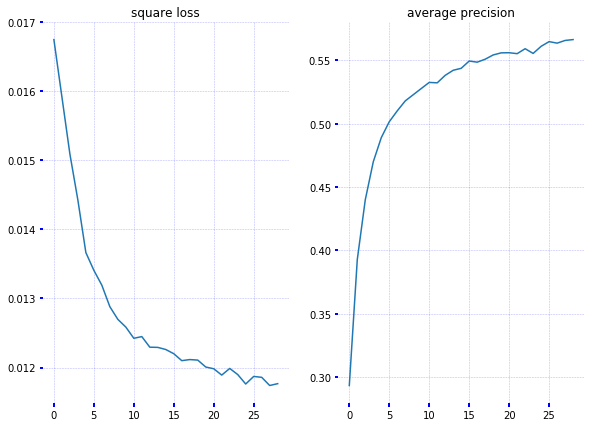

In [14]:
burnin = 1

fig = plt.figure(figsize=(15, 7))
fig.add_axes()

ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)

for ax in [ax1, ax2]:
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.grid(color='b', linestyle='--', linewidth=0.5, alpha=0.3)
    ax.tick_params(direction='out', color='b', width='2')
    
ax1.set_title('square loss')
ax1.plot(np.arange(len(loss_history[burnin:])), loss_history[burnin:])
ax2.set_title('average precision')
ax2.plot(np.arange(len(avgp_history[burnin:])), avgp_history[burnin:])

# Реал тест на наруте

In [15]:

try:
    with train_set, test_set:
        print ('square loss\tavg prec\ttime\t\tutime')
        for epoch in range(50):
            t = time()
            for x, y in train_loader:
                x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                loss = L(model(x),y)
                
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
                model.average_iterates()

            t1 = time()
            avgp, loss = 0., 0.
            yground = torch.FloatTensor(batch_size*len(test_loader), m)
            yhat = torch.FloatTensor(batch_size*len(test_loader), m)
            with averages(model):
                for i, (x, y) in enumerate(naruto_loader):
                    x, y = Variable(x.cuda(), requires_grad=False), Variable(y.cuda(), requires_grad=False)
                    yhatvar = model(x)
                    print(yhatvar)
                    loss += L(yhatvar,y).data[0]
                    yground[i*batch_size:(i+1)*batch_size,:] = y.data
                    yhat[i*batch_size:(i+1)*batch_size,:] = yhatvar.data
            avgp = average_precision_score(yground.numpy().flatten(),yhat.numpy().flatten())
            loss_history.append(loss/len(test_loader))
            avgp_history.append(avgp)
            torch.save(model.state_dict(), os.path.join(checkpoint_path,checkpoint))
            print ('{:2f}\t{:2f}\t{:2f}\t{:2f}'.format(loss_history[-1],avgp_history[-1],time()-t, time()-t1))

except KeyboardInterrupt:
    print ('Graceful Exit')
else:
    print ('Finished')

square loss	avg prec	time		utime


/opt/conda/envs/pytorch-py3.6/lib/python3.6/site-packages/torch/nn/modules/container.py:67: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


RuntimeError: multi-target not supported at /pytorch/torch/lib/THCUNN/generic/ClassNLLCriterion.cu:16